In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("../data/crime.csv", parse_dates=True, encoding="utf-8", 
                 index_col=["object_id", "date"])
level_values = df.index.get_level_values

In [3]:
df_agg = df.groupby([level_values(0)] + [pd.Grouper(freq='W', closed='left', level=-1)]).agg(
    events =  ("cassualties", "count"),
    cassualties = ("cassualties", "sum"),
    lat = ("lat", "first"),
    lon = ("lon", "first"),
    postal_code = ("postal_code", "first"),
    mun_name = ("mun_name", "first"),
    neighborhood_name = ("neighborhood_name", "first"),
    neighborhood_type = ("neighborhood_type", "first")
)

In [4]:
df_agg.sort_index(level=['object_id','date'], inplace=True, ascending=[True, True])

### Re-index semanas.

In [5]:
f = lambda x: np.where(df_agg.index.levels[1] == x)[0][0]
df_agg["week_id"] = list(map(f, df_agg.index.get_level_values(1)))

In [6]:
df_agg["object_id"] = df_agg.index.get_level_values(0)

In [7]:
df_agg.set_index(["week_id", "object_id"], inplace=True)

In [8]:
idx = pd.IndexSlice

### Get same week tuples

In [9]:
from itertools import combinations

In [10]:
network = set([])
for i in df_agg.index.levels[0]:
  network.update(list(combinations(df_agg.loc[idx[i, :], :].index.get_level_values(1).tolist(),2)))

### Display the network

In [11]:
network = pd.DataFrame(np.array([[t[0], t[1]] for t in network]), 
                                columns = ["source", "target"])

In [12]:
map_df = pd.read_csv("../data/map_df_all.csv")

In [13]:
nodeData = map_df[["object_id", "mun_name", "neighborhood_name", "neighborhood_type", 
                   "area", "x_centroid", "y_centroid", "with_event"]].set_index("object_id").to_dict('index')

In [14]:
import networkx as nx

In [15]:
G = nx.from_pandas_edgelist(network)
G.add_nodes_from(map_df.object_id)
nx.set_node_attributes(G, nodeData)

In [25]:
y = nx.get_node_attributes(G, "y_centroid")
x = nx.get_node_attributes(G, "x_centroid")     
pos = {key:[x[key],y[key]] for key in y.keys()}
pos[0] = [-99.949, 25.97]

/home/dianae/Workspace/crimenNL/vcrime/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


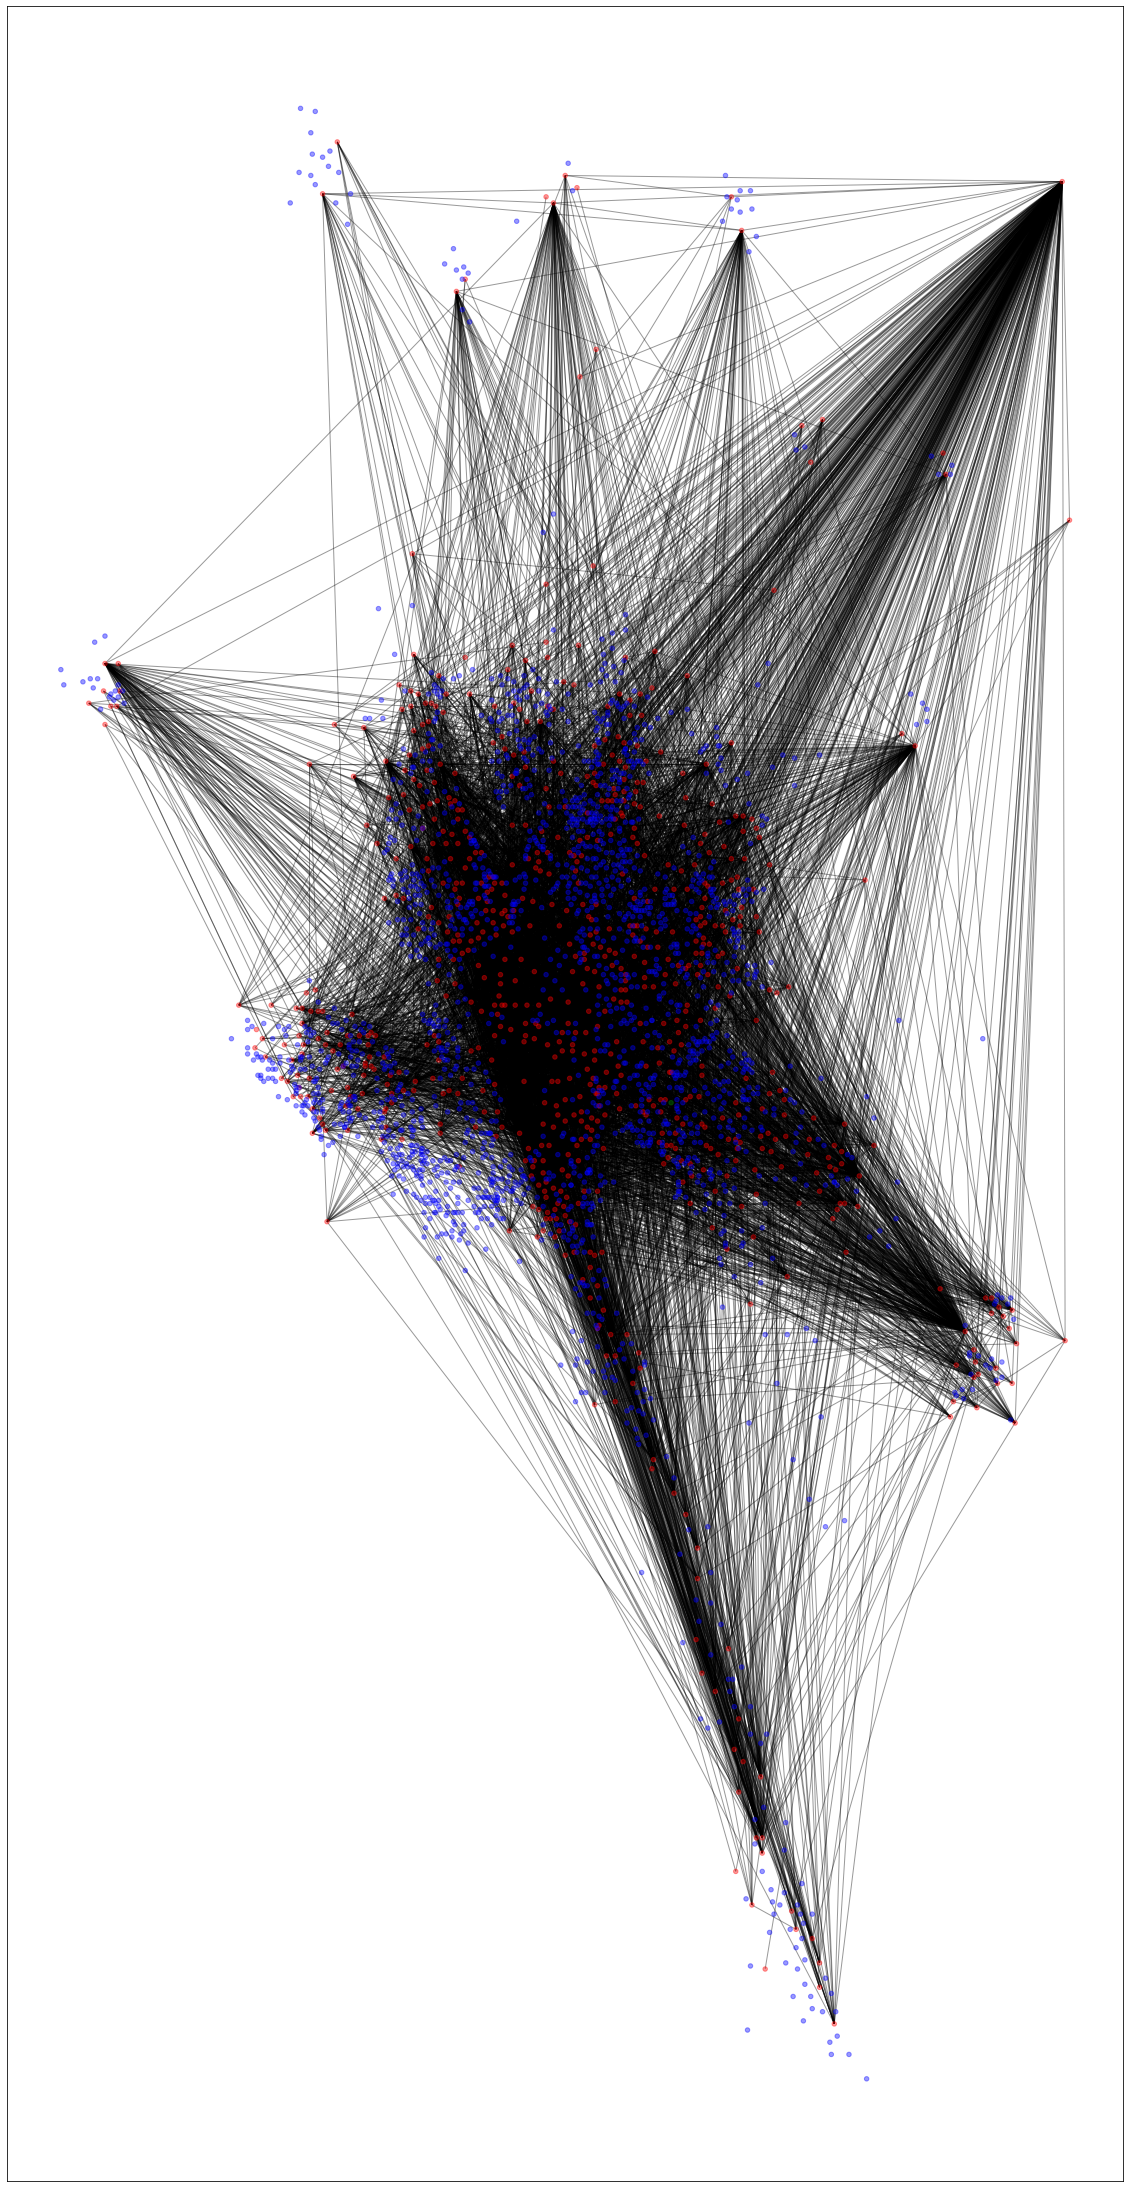

In [29]:
plt.figure(figsize=(20, 40))
color = ["green"] + ["red" if val else "blue" for key, val in nx.get_node_attributes(G, "with_event").items()]
nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

### Now with edge weight according to tuple appearances

In [60]:
network = []
for i in df_agg.index.levels[0]:
    comb = list(combinations(df_agg.loc[idx[i, :], :].index.get_level_values(1).tolist(), 2))
    if comb:
        network.append(np.insert(np.array(comb), 2,  [i], axis = 1))

In [64]:
network_df = pd.DataFrame(np.concatenate(network), columns = ["source", "target", "week_id"])

In [70]:
network_agg = network_df.groupby(["source", "target"]).agg(weight=('week_id', "count")).reset_index()
network_agg.sort_values('weight', ascending=False)

source  target  weight
222        0   34955      36
1826   33901   34955      22
67         0   33901      20
4859   34955   35376      18
1885   33901   35376      13
...      ...     ...     ...
2542   34041   35264       1
2541   34041   35259       1
2540   34041   35257       1
2539   34041   35251       1
7128   36488   36502       1

[7129 rows x 3 columns]

In [71]:
G = nx.from_pandas_edgelist(network_agg, edge_attr= "weight")
G.add_nodes_from(map_df.object_id)
nx.set_node_attributes(G, nodeData)

In [72]:
y = nx.get_node_attributes(G, "y_centroid")
x = nx.get_node_attributes(G, "x_centroid")     
pos = {key:[x[key],y[key]] for key in y.keys()}
pos[0] = [-99.949, 25.97]

/home/dianae/Workspace/crimenNL/vcrime/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


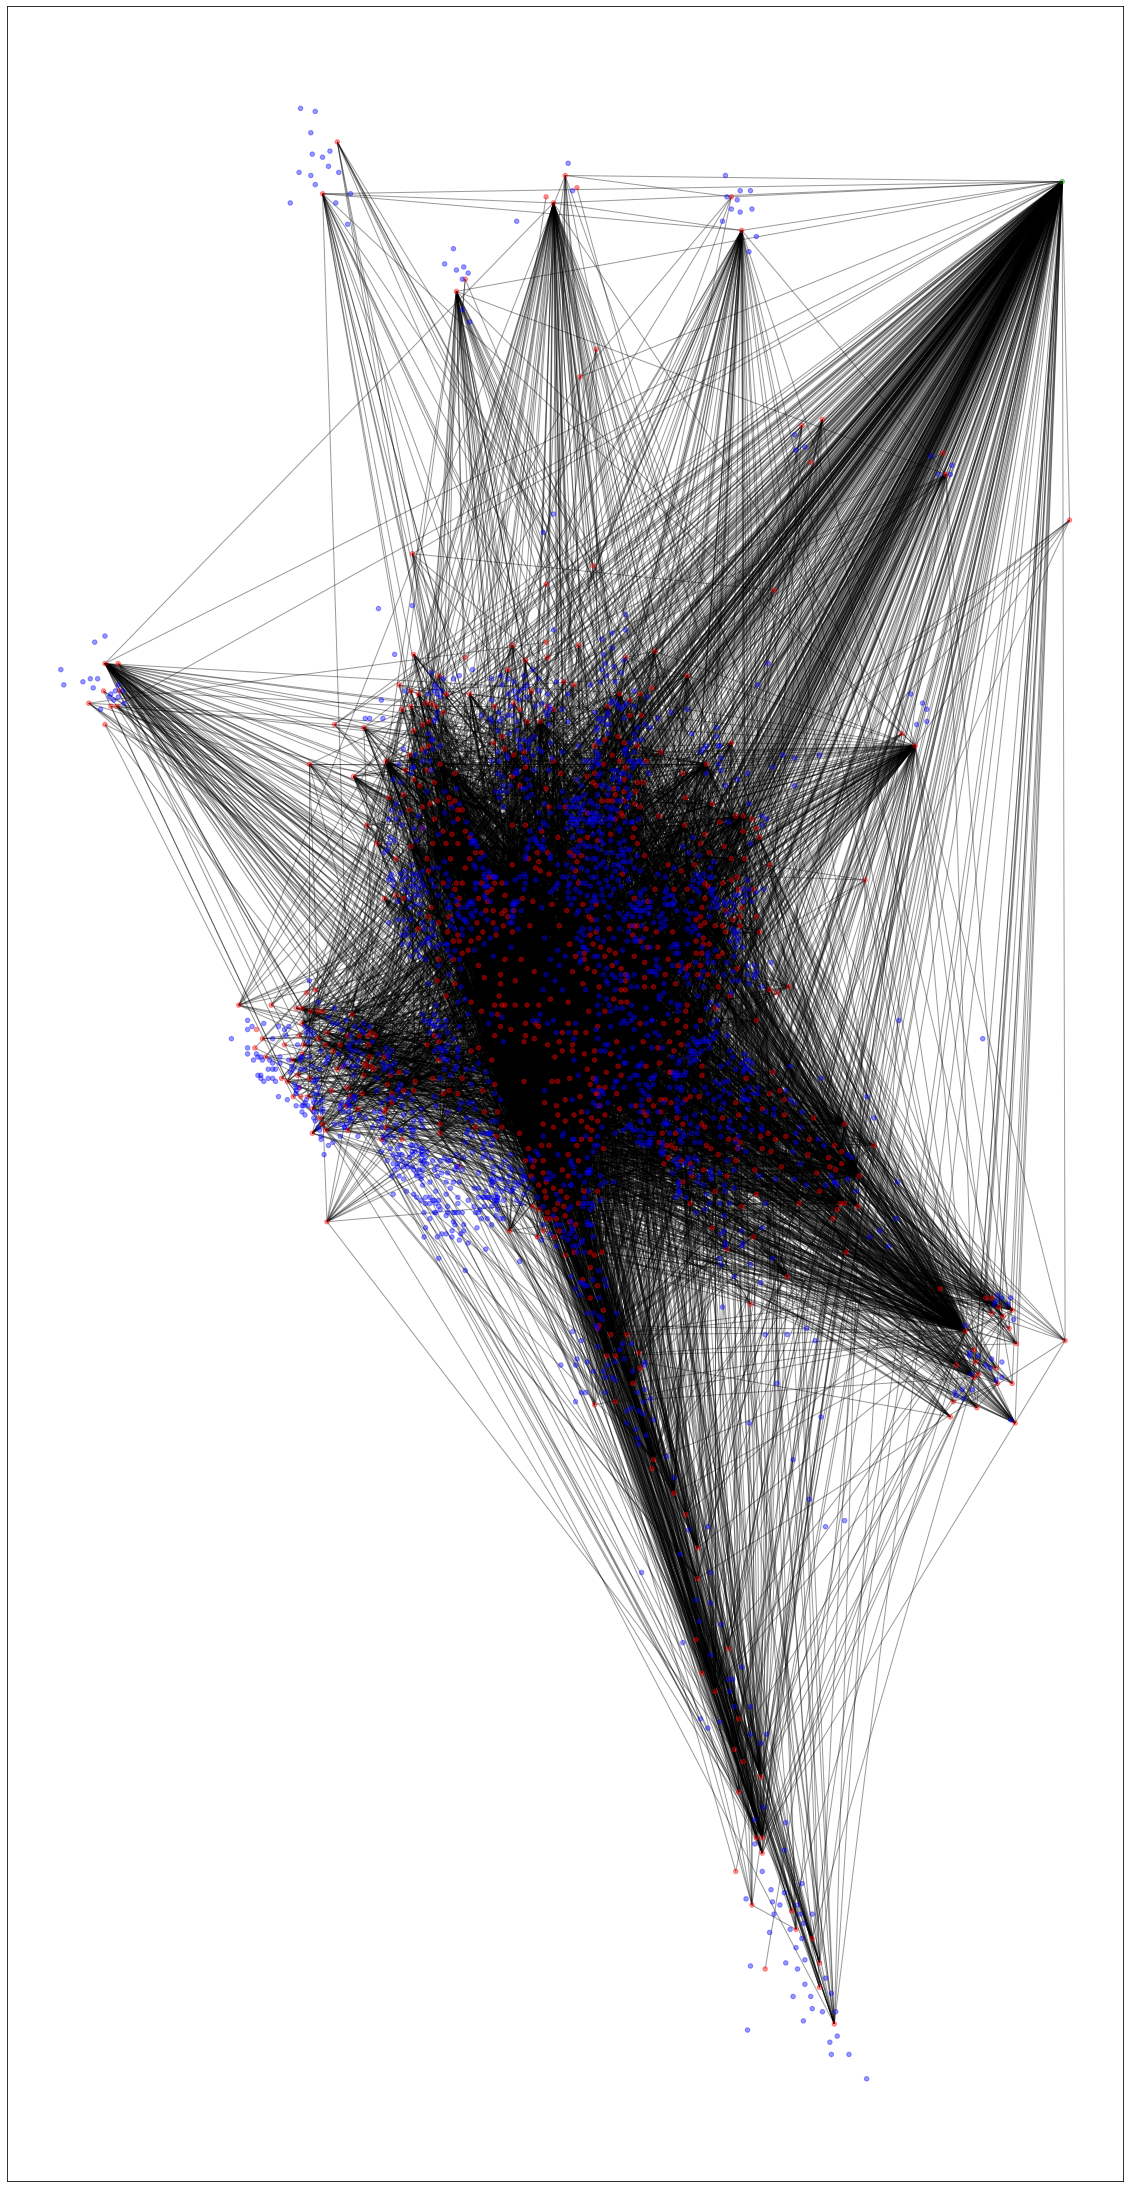

In [73]:
plt.figure(figsize=(20, 40))
color = ["green"] + ["red" if val else "blue" for key, val in nx.get_node_attributes(G, "with_event").items()]
nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

In [74]:
network_agg.to_csv("../data/network_same_week.csv", index=False)